## Read space-time dataset 

A space-time matrix is a structure with time series of observed displacements. The current files has been produced in Matlab. In Python we can read this dataset and store the contents in a dictionary

In [9]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import xarray as xr
import os
import statsmodels.api as sm
from scipy import linalg
from matplotlib import pyplot as plt

from scipy import signal
from scipy.stats.distributions import chi2
from staticTSAfunctions import *
from labfunctions import *
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

from astropy.timeseries import LombScargle
from scipy.spatial import Delaunay
# To work with sparse matrices when we unwrap
from scipy.sparse import csr_matrix
# To solve the linear set of equations
from scipy.sparse.linalg import lsqr
from scipy.interpolate import griddata
from datetime import datetime
from drama import utils


In [10]:
#load GNSS data
stm = scipy.io.loadmat('06gps_nam_2006-2024.mat')

In [11]:
stm.keys()

dict_keys(['__header__', '__version__', '__globals__', 'datasetId', 'techniqueId', 'datasetAttrib', 'techniqueAttrib', 'numPoints', 'numEpochs', 'pntName', 'pntCrd', 'pntAttrib', 'epochDyear', 'epochAttrib', 'parTypes', 'obsTypes', 'auxTypes', 'obsData', 'auxData', 'sensitivityMatrix', 'stochModel', 'stochData', 'inputDatasets', 'globalAttrib'])

## Point names and coordinates, epoch times and observations types

The displacement timeseries are stored in the field with key 'obsData'. The displacements are stored as a three dimensional matrix. The first dimension (rows) are for the points, the second dimension (columns) is for the epochs, and the third dimension (pages) is for different observation types.

The point names and geographic coordinates (Latitude, Longitude, Height above ellipsoid) are stored in the fields with keys 'pntName' and 'pntCrd'.  The epoch times - in decimal years - are stored in the field with key 'epochDyear', and observation types in the field with key 'obsTypes'.

In [12]:
pntName=stm['pntName']
pntCrd=stm['pntCrd']
epochDyear=stm['epochDyear'][0]
obsTypes=stm['obsTypes']

obsData=stm['obsData']

### Check what GNSS station is in the Insar region

In [13]:
# Filtering data based on latitude and longitude conditions

filtered_data = pntCrd[(pntCrd[:,0] >= 53.08) & (pntCrd[:,0] <= 53.2) &
                             (pntCrd[:,1] >= 6.35) & (pntCrd[:,1]<= 6.64)]
# # Extracting names from the first column for the filtered data
# station_names_in_region = pntName[li]
# print(station_names_in_region.size)
print(filtered_data)

# Step 2: Find the indices of the matching rows
matching_indices = []
for row in filtered_data:
    index = np.where((pntCrd == row).all(axis=1))[0]
    if index.size > 0:
        matching_indices.append(index[0])

print("Matching Indices:")
print(matching_indices)

# Step 3: Extract the station names using the indices
station_names_in_region = pntName[matching_indices]
print("Station Names in Region:")
print(station_names_in_region)

# print(np.where(pntCrd==filtered_data))
# print(f'GNSS station in our are Insar area {pntName[43]}')

[[53.14831577  6.60464521 45.42766774]
 [53.11191407  6.40277251 48.6615242 ]
 [53.09005597  6.43096471 57.4118744 ]
 [53.13637818  6.44928672 45.61663657]]
Matching Indices:
[27, 34, 35, 43]
Station Names in Region:
[[array(['HARE'], dtype='<U4')]
 [array(['NOR3'], dtype='<U4')]
 [array(['NORG'], dtype='<U4')]
 [array(['RDN1'], dtype='<U4')]]


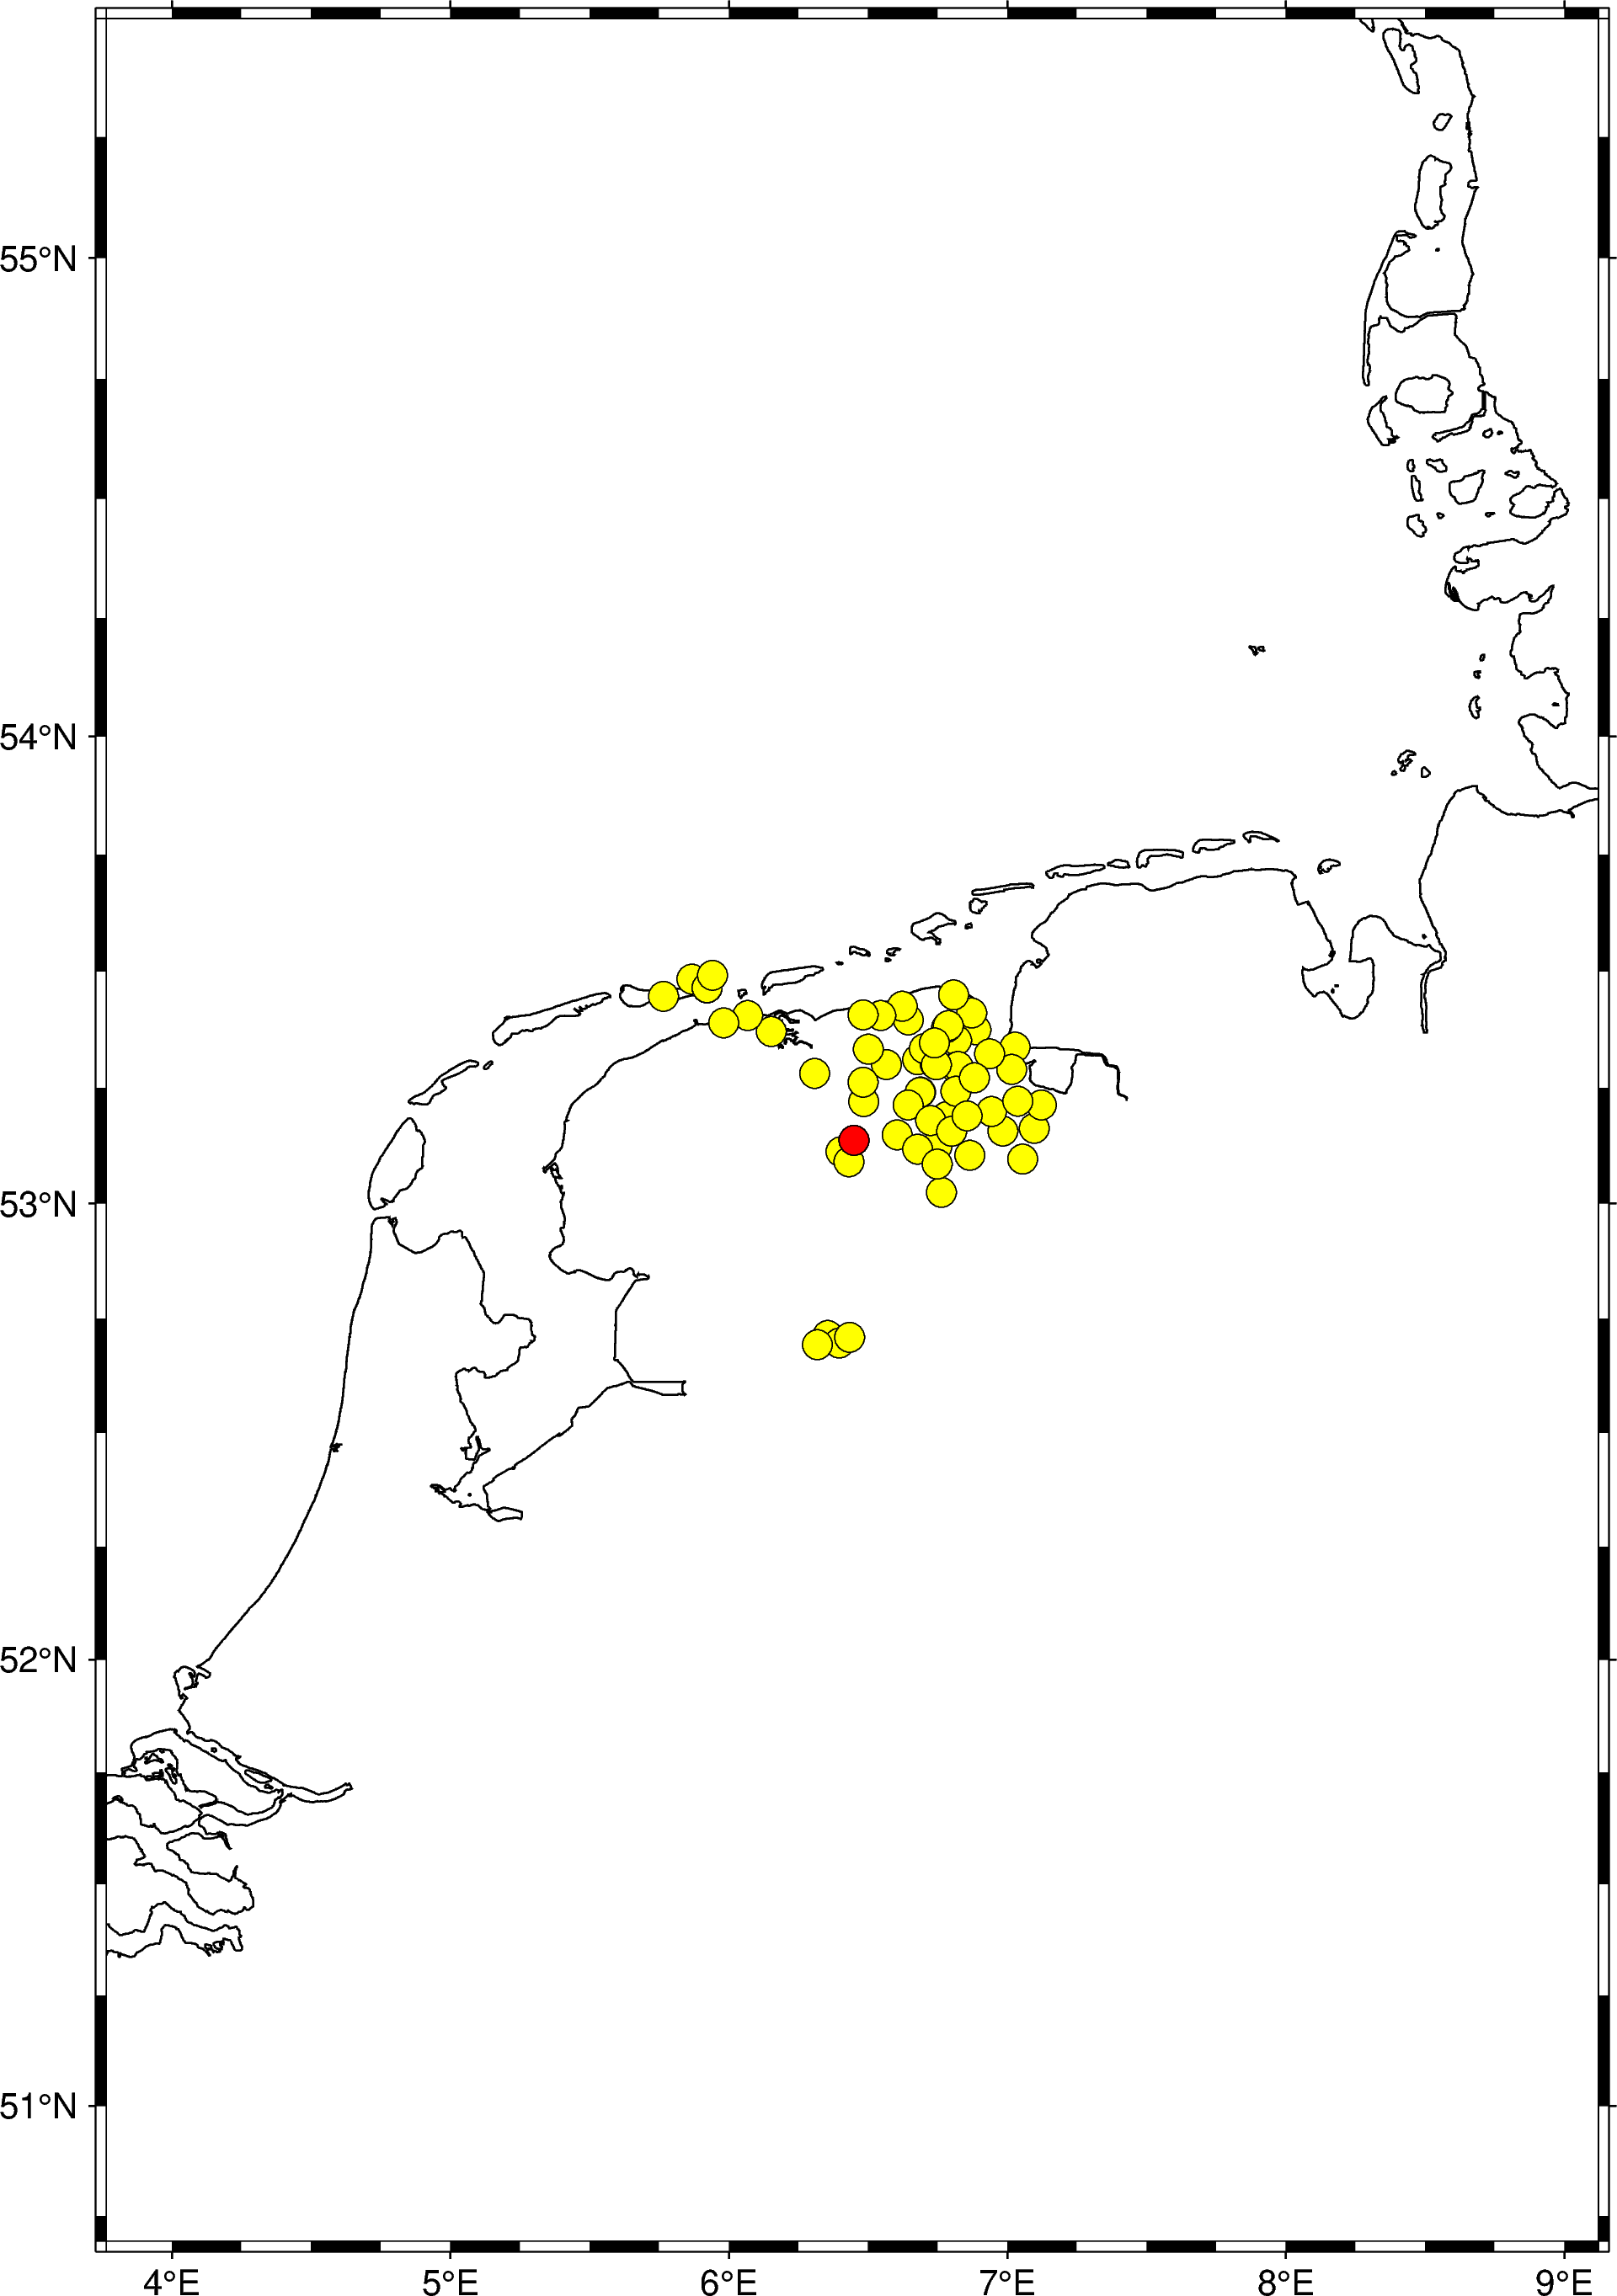

In [14]:
#plot map with GNSS stations
lonmin= np.min(pntCrd[:,1])
lonmax= np.max(pntCrd[:,1])
latmin= np.min(pntCrd[:,0])
latmax= np.max(pntCrd[:,0])

region = [
    lonmin-2,
    lonmax+2,
    latmin-2,
    latmax+2,
]

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(shorelines="1/0.5p,black")
fig.plot(x= pntCrd[:,1],y= pntCrd[:,0], style="c0.3c", fill="yellow", pen="black")
fig.plot(x= 6.44928672,y= 53.13637818, style="c0.3c", fill="red", pen="black")
fig.show()


For convenience we convert the array with point names and observation types to a list

In [15]:
pntList= [ pntName[x][0][0] for x in np.arange(0,pntName.shape[0]) ]
obsList= [ obsTypes[0][x][0] for x in np.arange(0,obsTypes.shape[1]) ]

In [16]:
print('obsData.shape', obsData.shape)
print('len(pntList)', len(pntList))
print('epochDyear.shape', epochDyear.shape)

obsData.shape (62, 6434, 3)
len(pntList) 62
epochDyear.shape (6434,)


## Finding the time series for a station

To obtain the time series for different GNSS stations

In [17]:
pnum=pntList.index('RDN1') #fill in station id here: RDN1, NOR3, NORG
updisplacements=obsData[pnum,:,2]
northdisplacements=obsData[pnum,:,0]
eastdisplacements=obsData[pnum,:,1]


## Plot the time series

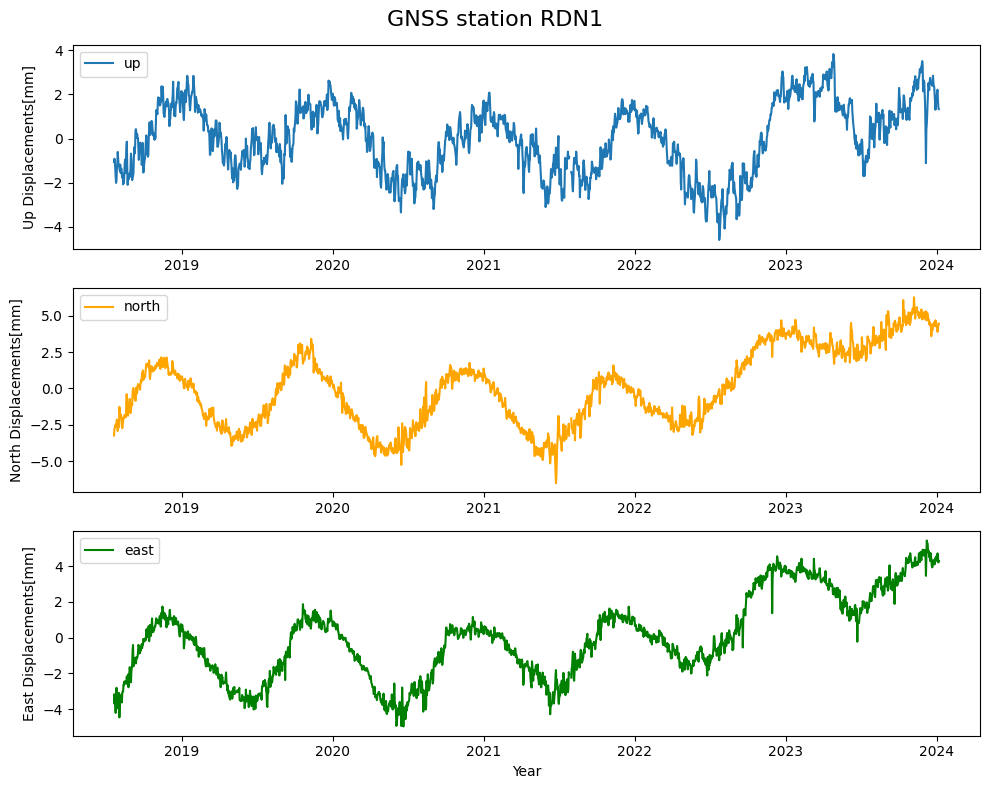

In [18]:
# Creating the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plotting the up displacements
axs[0].plot(epochDyear, updisplacements, label='up')
axs[0].set_ylabel('Up Displacements[mm]')
axs[0].legend()

# Plotting the north displacements
axs[1].plot(epochDyear, northdisplacements, label='north', color='orange')
axs[1].set_ylabel('North Displacements[mm]')
axs[1].legend()

# Plotting the east displacements
axs[2].plot(epochDyear, eastdisplacements, label='east', color='green')
axs[2].set_ylabel('East Displacements[mm]')
axs[2].set_xlabel('Year')
axs[2].legend()

# Adding a general title
fig.suptitle(f'GNSS station RDN1', fontsize=16)
# Adjusting the layout
plt.tight_layout()



In [19]:

# Combine into a DataFrame

data =  pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,0],
    'Deformations East': obsData[pnum,:,1],
    'Deformations Up': obsData[pnum,:,2]
})

data = data.dropna()


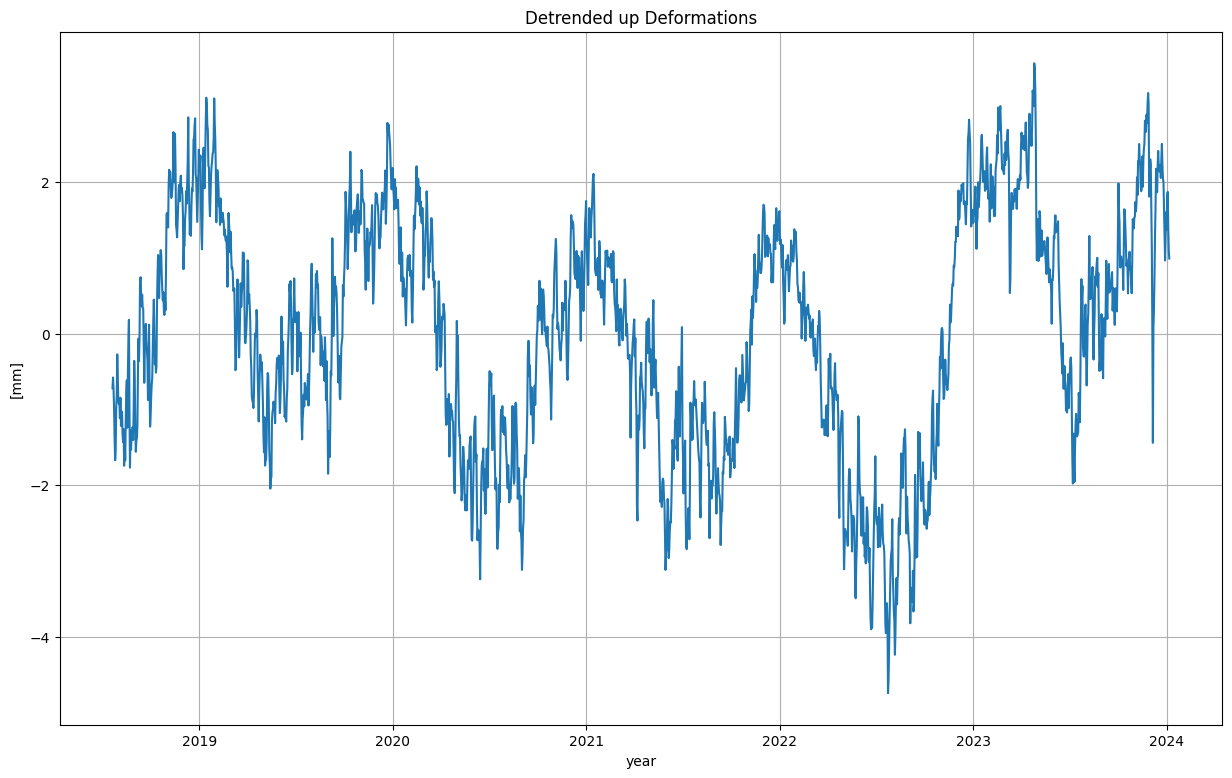

In [20]:
#detrend the data as prep for periodogram
detrended_data = signal.detrend(data['Deformations Up'], axis=-1, type='linear', bp=0, overwrite_data=False)
plt.figure(figsize=(15,9))
plt.title('Detrended up Deformations')
plt.plot(data['Year'],detrended_data)
plt.ylabel('[mm]')
plt.xlabel('year')
plt.grid()

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_60378/2143957331.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$t [years]')


Text(0.5, 1.0, 'time sample size')

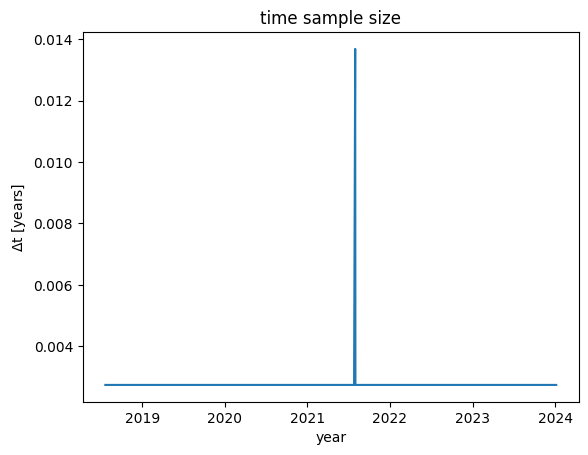

In [21]:
#check time sample spacing, check if spacing is even
stepsize= data['Year'].diff()
plt.plot(data['Year'], stepsize)
plt.ylabel('$\Delta$t [years]')
plt.xlabel('year')
plt.title('time sample size')



### because of the removal of the nan's there are now some uneven time step sizes. therefor we use Lomb Scargle periodogram of detrended data

Text(0.5, 1.0, 'Lomb-Scargle periodogram of detrended time series, RDN1-HARE, max peak at period 1.0 year')

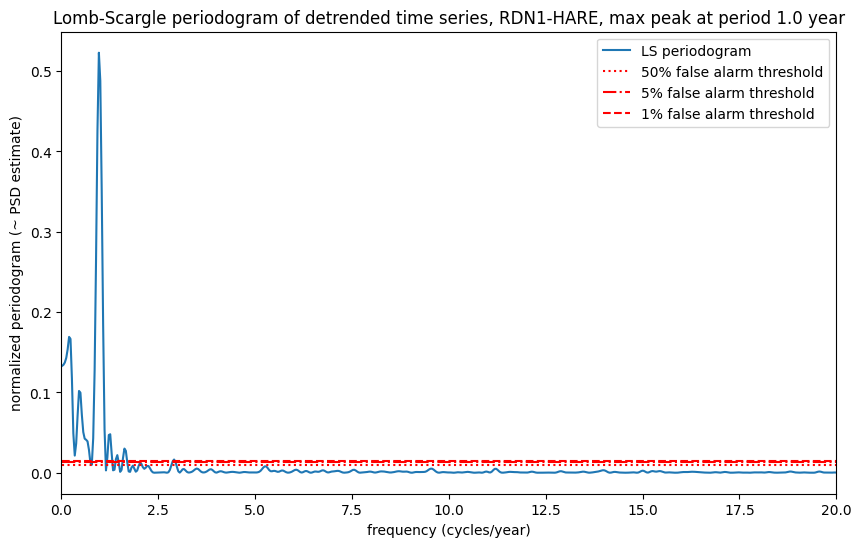

In [22]:
# perform a Lomb Scargle periodogram of the detrended data for uneven spacing


LS = LombScargle(data['Year'], detrended_data)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
plt.xlim(0,20)
plt.ylabel('normalized periodogram (~ PSD estimate)')


freq_max = frequency[power.argmax()]
plt.title('Lomb-Scargle periodogram of detrended time series, RDN1-HARE, max peak at period {} year'.format(round(1/freq_max,1)))


## Fitting a time series model using Space State Model (SSM) **

1. **Experiment no 1: Stochastic trend + white observation noise:** 
  1 - Random walk with constant drift 
    check state variance. if near zero -> use static trend
    2- Intergated random walk

2. **Experiment no 2: Stochastic trend (integrated random walk) + annual cycle  + white observation noise.** Based on the updated Lomb-Scargle periodogram for this case. 
  check state variance. if near zero -> use static trend
3. **Static trend + stocastic annual cycle +white noise**

4. **Experiment no 3: Stochastic trend (integrated random walk) + annual cycle + AR(1)**
Then adding order

## stochastic trend in the form of an random walk with constant drift + white noise

In [23]:
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': True, 
     'trend': True, 
     'stochastic_trend': False,
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()

['sigma2.irregular', 'sigma2.level']
['level', 'trend']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2

Optimization terminated successfully.
         Current function value: 0.313907
         Iterations: 2
         Function evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Unobserved Components Results                                
============================================================================================
Dep. Variable:                      Deformations Up   No. Observations:                 1992
Model:             local linear deterministic trend   Log Likelihood                -625.302
Date:                              Fri, 14 Jun 2024   AIC                           1254.605
Time:                                      07:26:14   BIC                           1265.797
Sample:                                           0   HQIC                          1258.715
                                             - 1992                                         
Covariance Type:                                opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.686e-09      0.002   8.49e-07      1.000      -0.004       0.004
sigma2.level         0.1093      0.005     23.721      0.000       0.100       0.118
===================================================================================
Ljung-Box (L1) (Q):                  26.40   Jarque-Bera (JB):                67.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.17
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


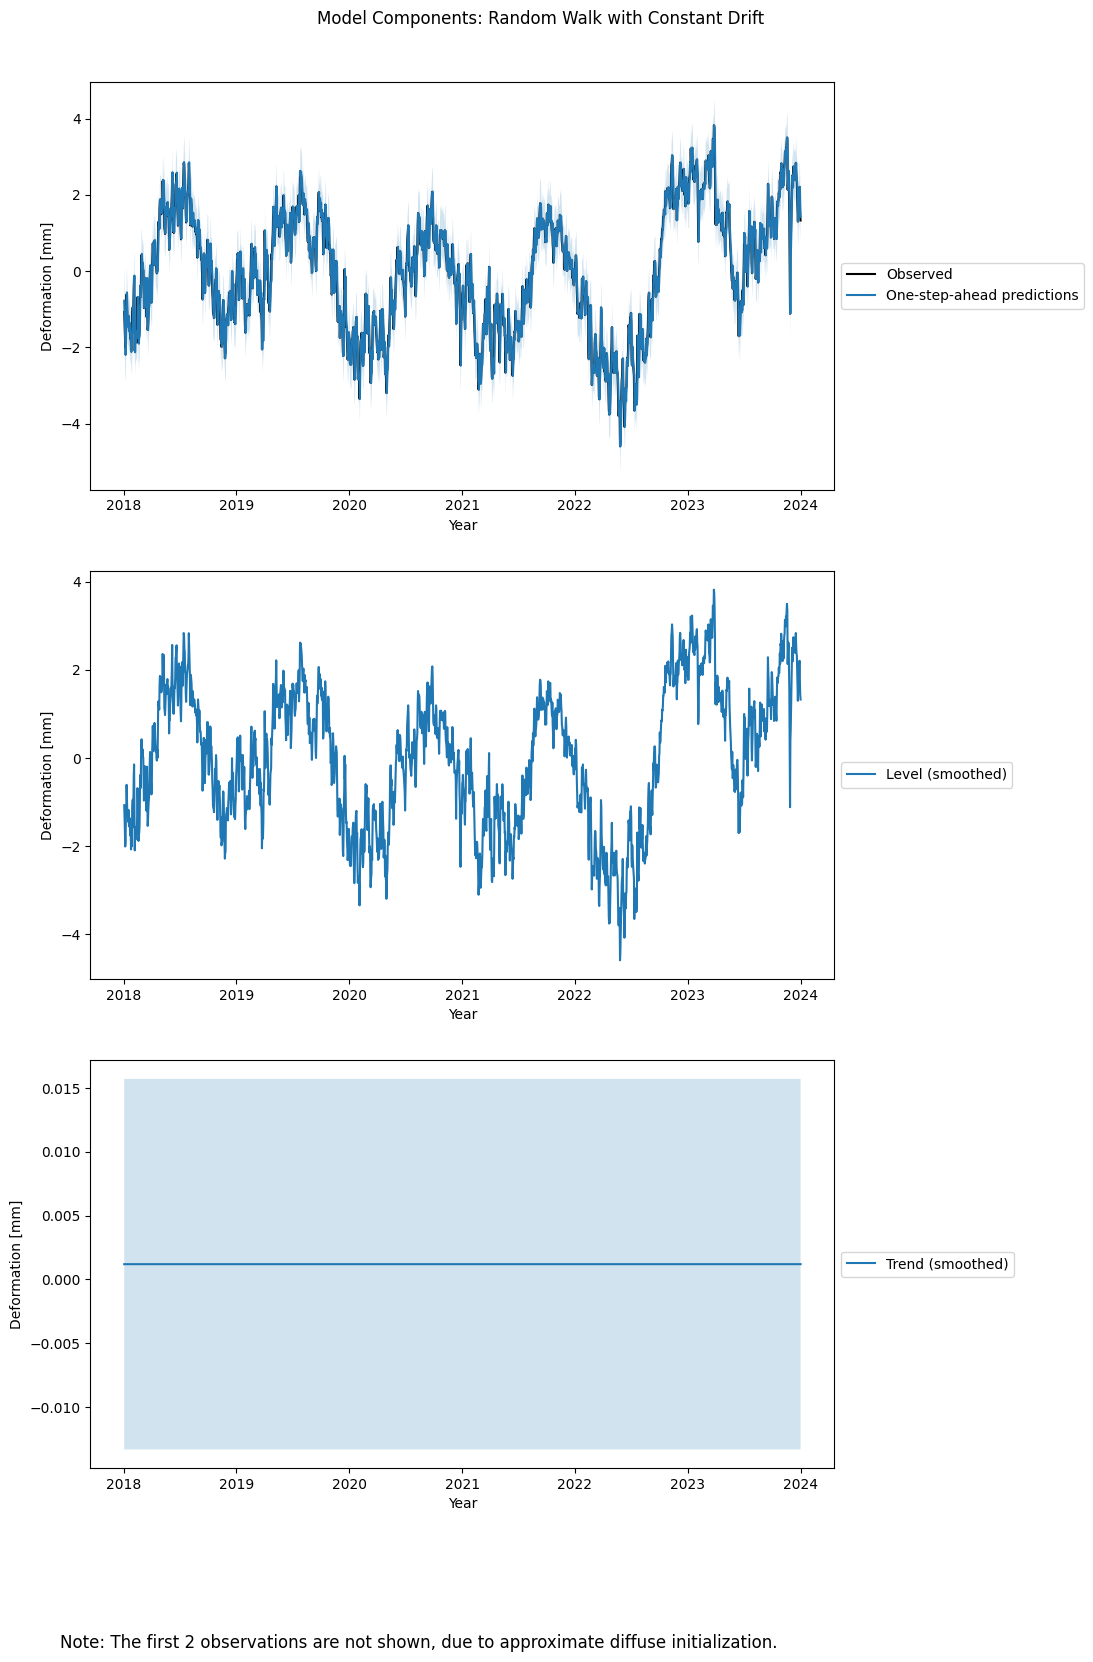

In [24]:
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components: Random Walk with Constant Drift", y=0.92)
plt.show()

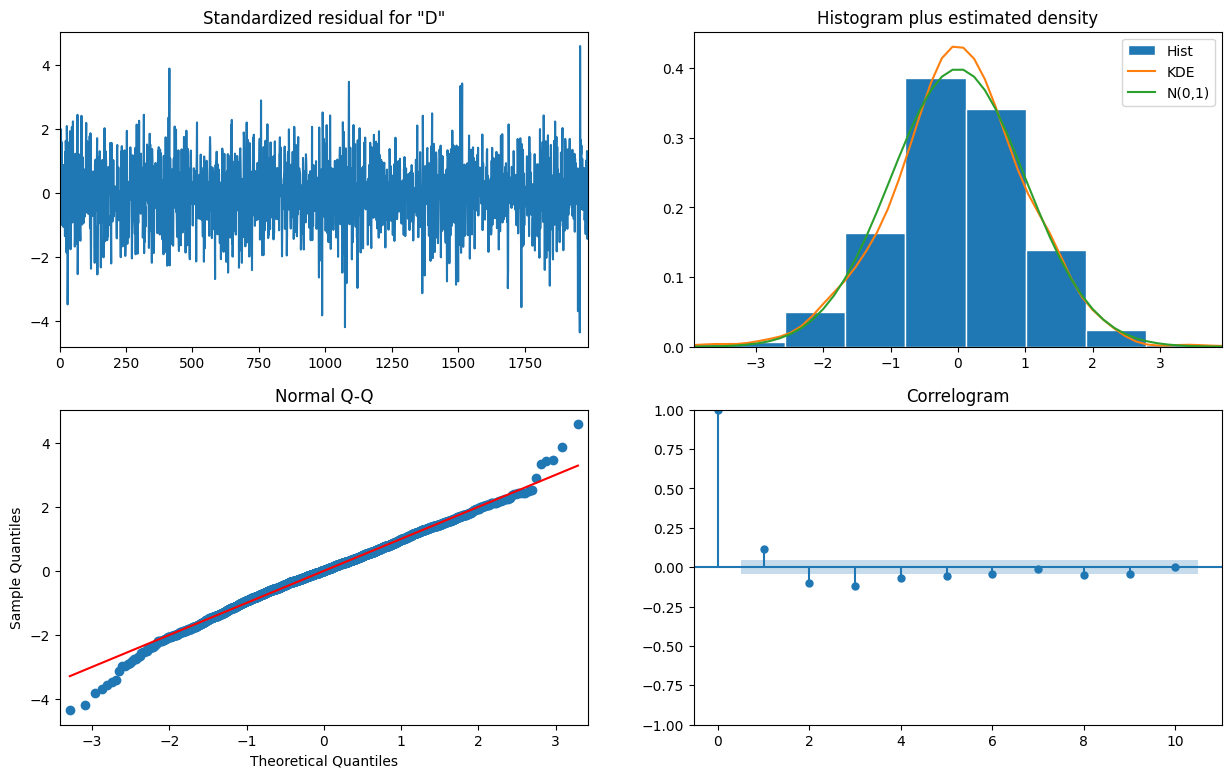

In [25]:
# plot states and their uncertainties
# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));


# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

### stochastic trend in the form of an integrated random walk + white noise

In [26]:
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()

['sigma2.irregular', 'sigma2.trend']
['level', 'trend']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2

Optimization terminated successfully.
         Current function value: 0.495347
         Iterations: 4
         Function evaluations: 115


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:        Deformations Up   No. Observations:                 1992
Model:                   smooth trend   Log Likelihood                -986.731
Date:                Fri, 14 Jun 2024   AIC                           1977.462
Time:                        07:26:23   BIC                           1988.654
Sample:                             0   HQIC                          1981.573
                               - 1992                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0327      0.001     27.667      0.000       0.030       0.035
sigma2.trend         0.0429      0.002     18.006      0.000       0.038       0.048
===================================================================================
Ljung-Box (L1) (Q):                  18.68   Jarque-Bera (JB):               138.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0.92, 'Model Components: Integrated random walk')

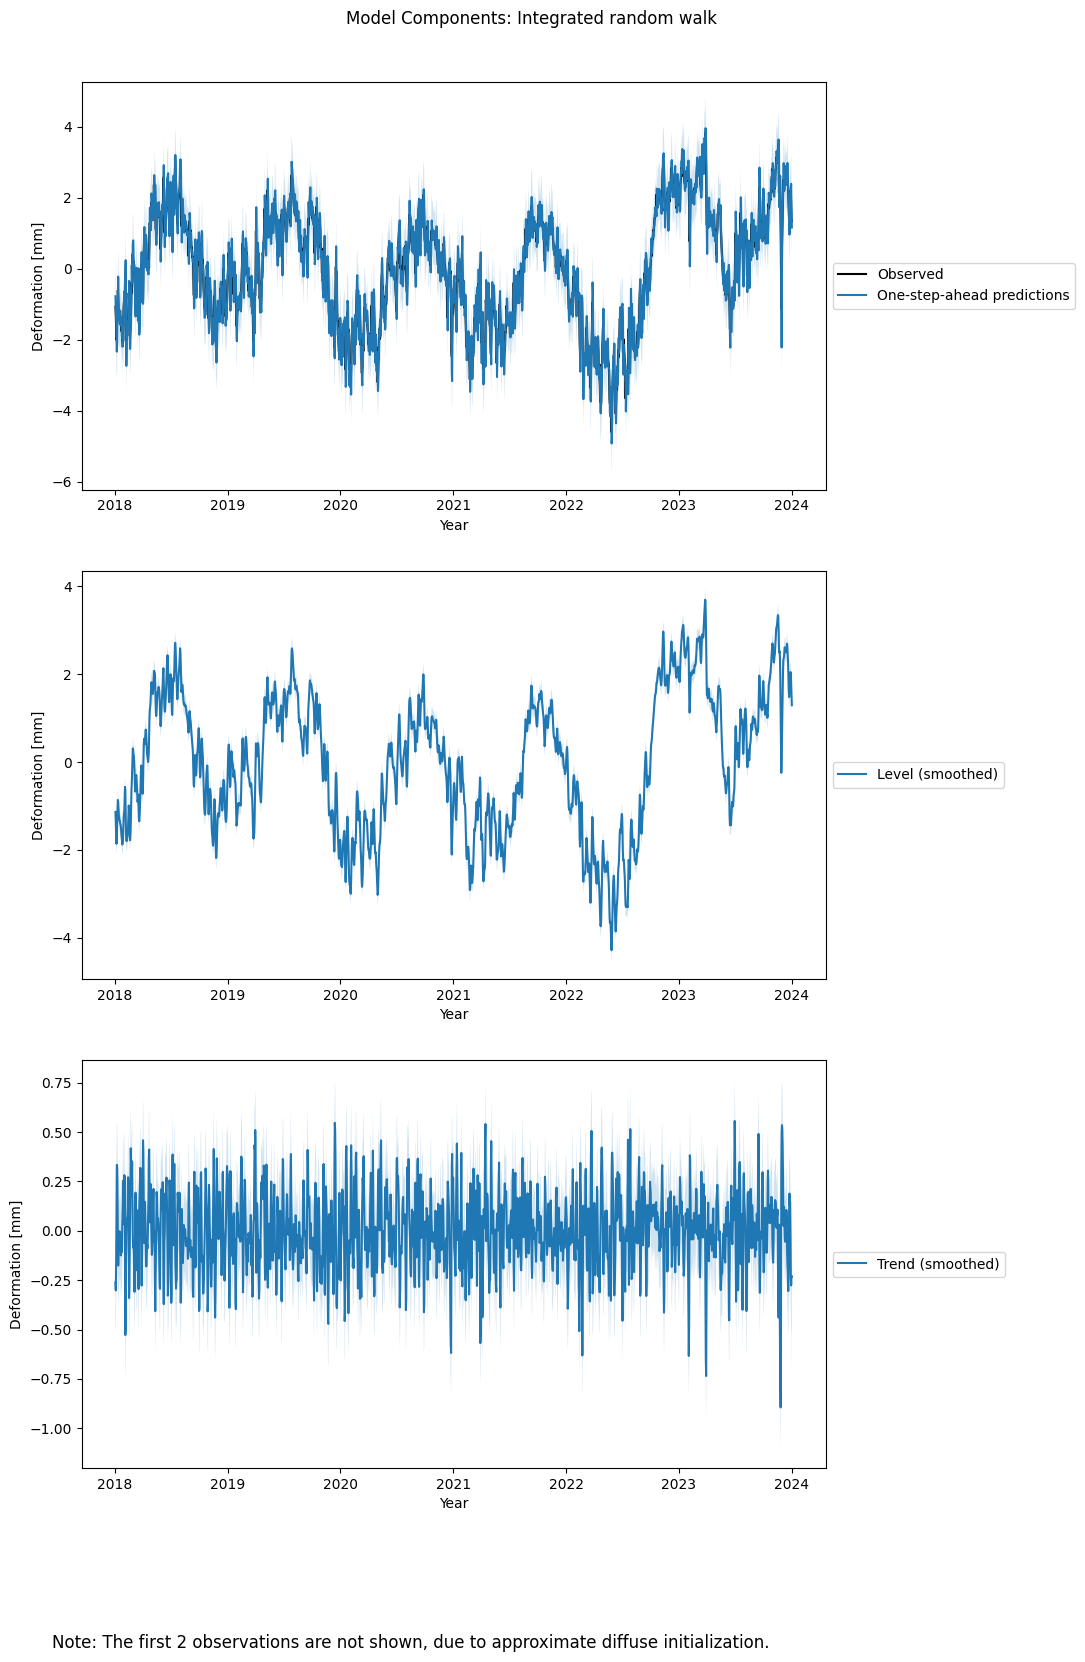

In [27]:
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components: Integrated random walk", y=0.92)

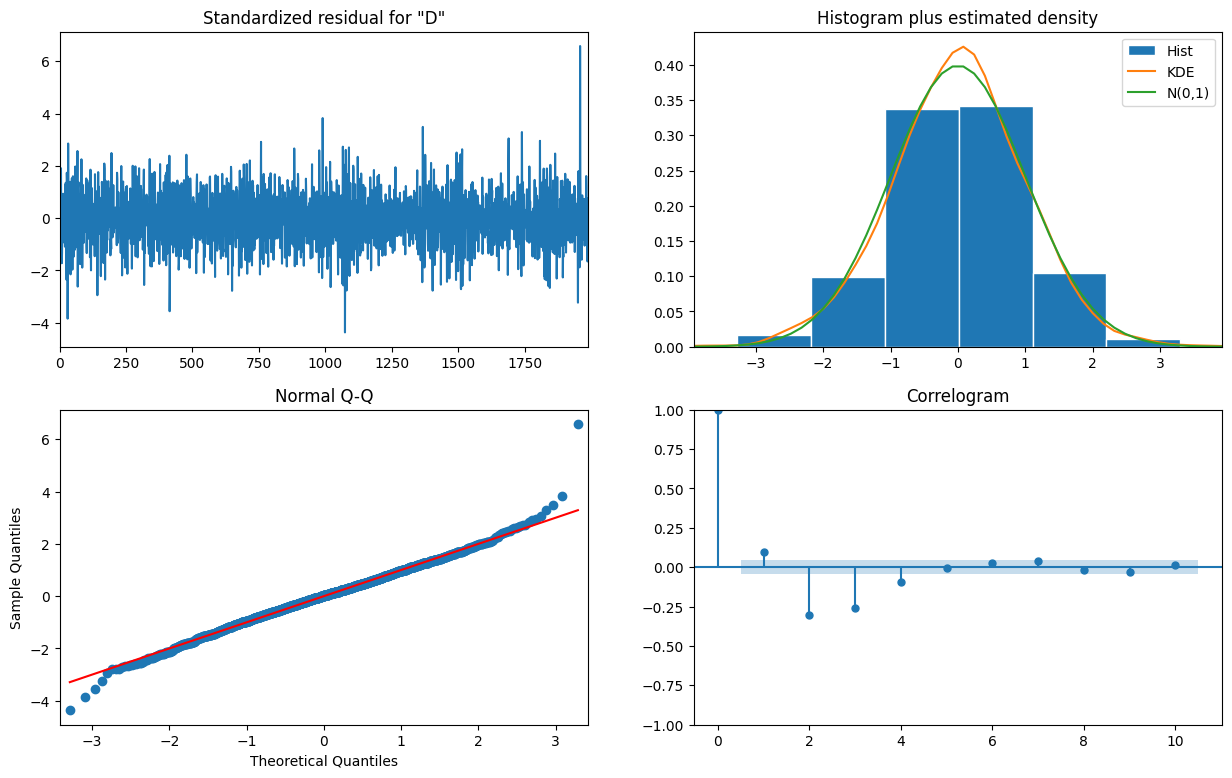

In [28]:

# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

## Integrated random walk + seasonal component

In [29]:
#find period of the signal
dt = np.mean(np.diff(data['Year']))
print(f'dt {dt} period {round(1/dt)} days')

dt 0.0027433512407476343 period 365 days


In [30]:
#stacastic trend + annual cycle

#frequency of the annual cycle
frequencies = [{'period': 365, 'harmonics': 1}]

# model settings
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)
# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()


['sigma2.irregular', 'sigma2.trend', 'sigma2.freq_seasonal_365(1)']
['level', 'trend', 'freq_seasonal.0', 'freq_seasonal.1']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4

Optimization terminated successfully.
         Current function value: 0.326787
         Iterations: 3
         Function evaluations: 162


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                        Deformations Up   No. Observations:                 1992
Model:                                   smooth trend   Log Likelihood                -650.959
                   + stochastic freq_seasonal(365(1))   AIC                           1307.918
Date:                                Fri, 14 Jun 2024   BIC                           1324.702
Time:                                        07:26:34   HQIC                          1314.082
Sample:                                             0                                         
                                               - 1992                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular             4.244e-14      0.002   2.12e-11      1.000      -0.004       0.004
sigma2.trend                 2.367e-09   2.72e-08      0.087      0.931   -5.09e-08    5.57e-08
sigma2.freq_seasonal_365(1)     0.1089      0.005     22.918      0.000       0.100       0.118
===================================================================================
Ljung-Box (L1) (Q):                  24.05   Jarque-Bera (JB):                65.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


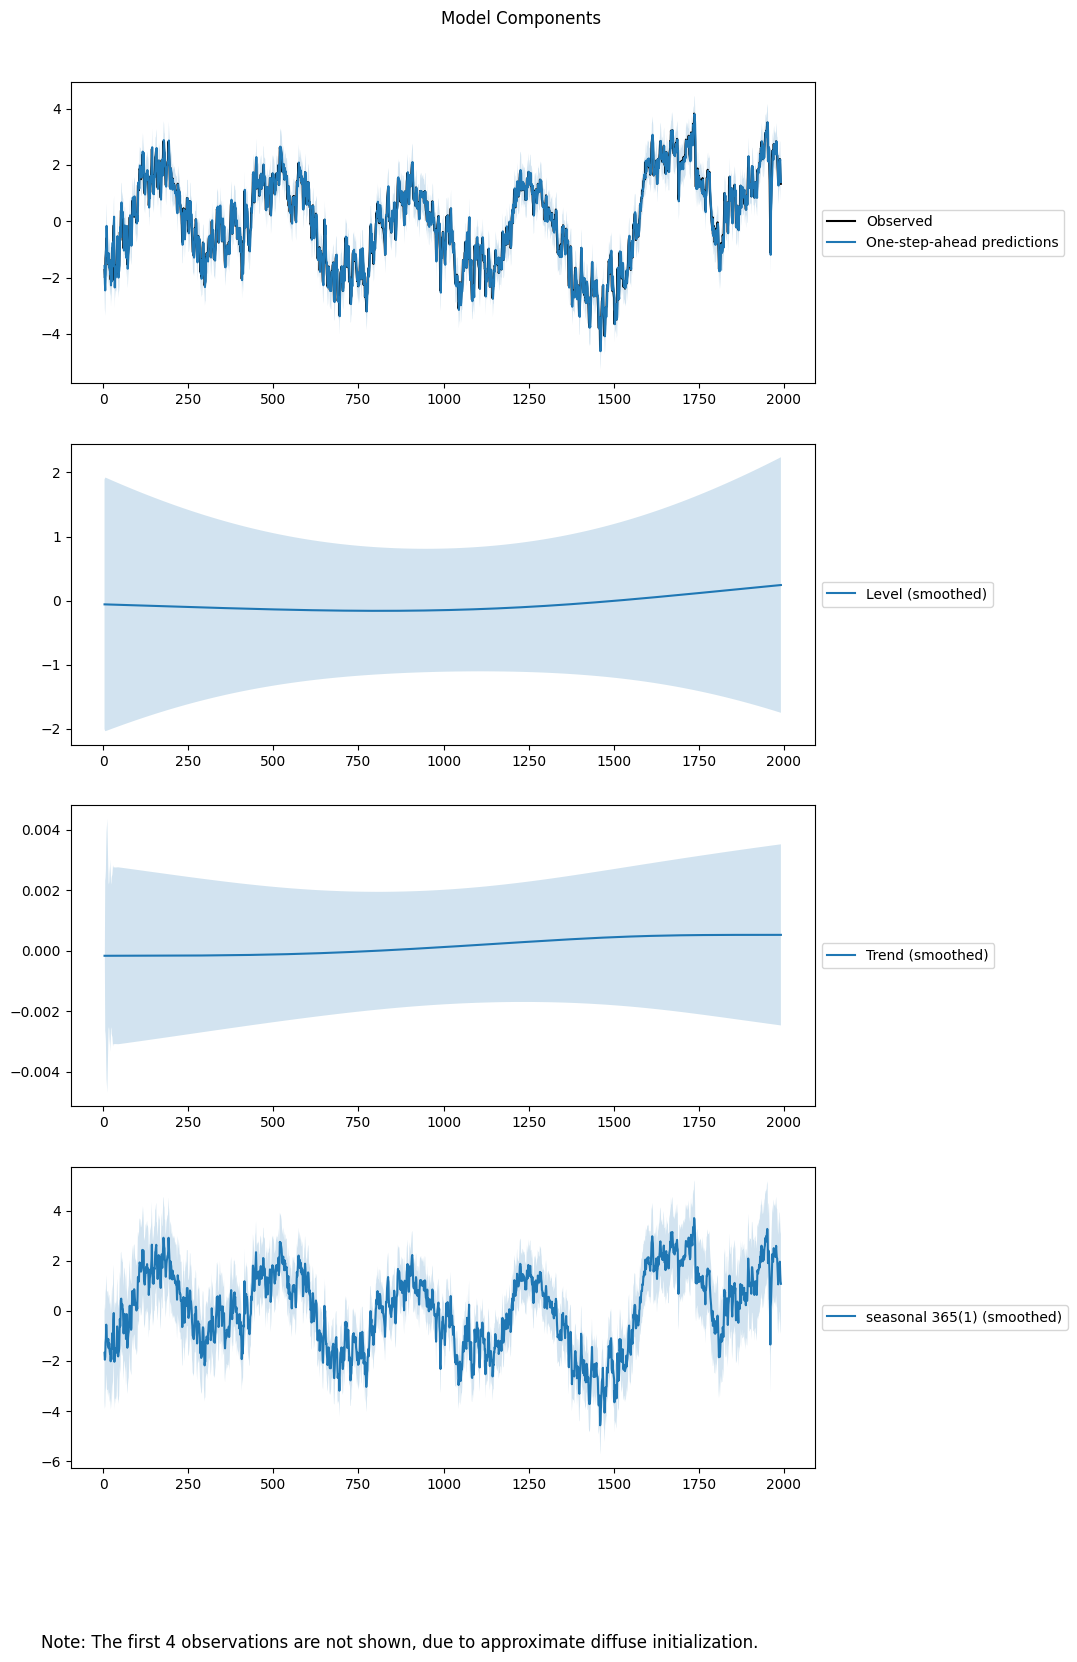

In [31]:
# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
fig.suptitle("Model Components", y=0.92);

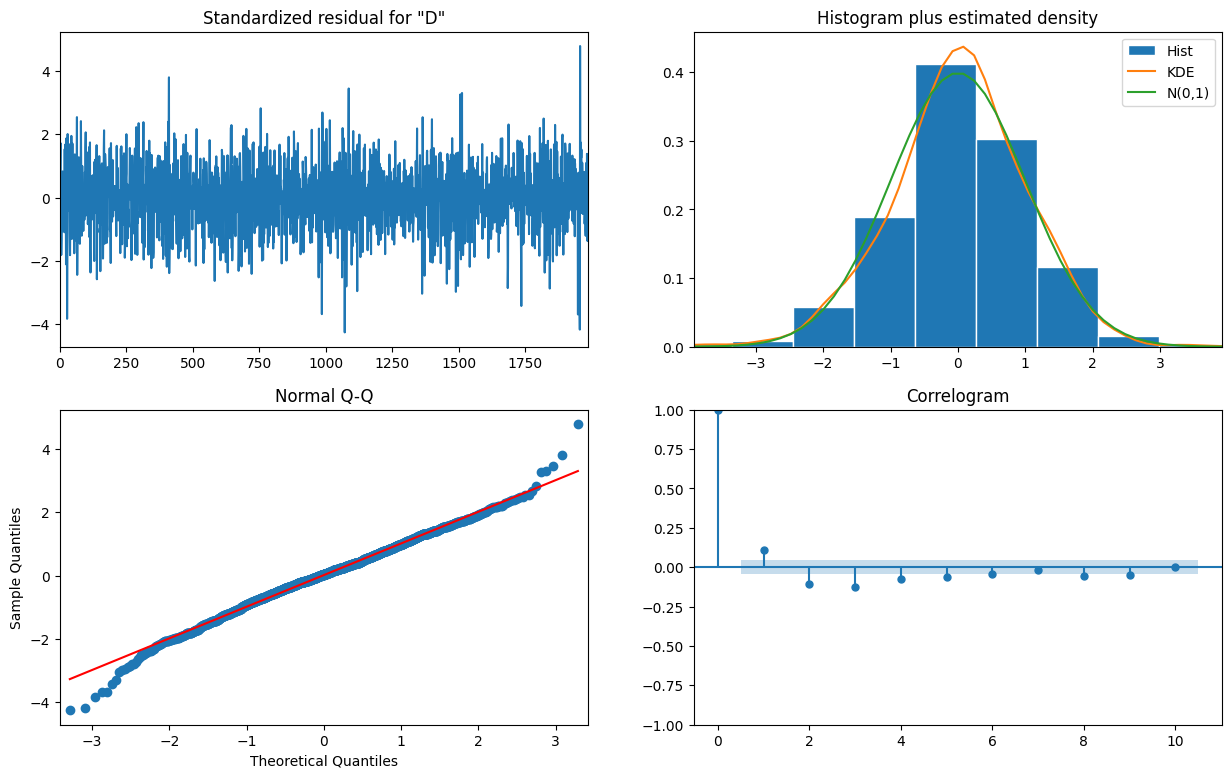

In [32]:
# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

** check the residuals if there is still a large peak in the spectrum **

Text(0, 0.5, 'normalized periodogram (~ PSD estimate)')

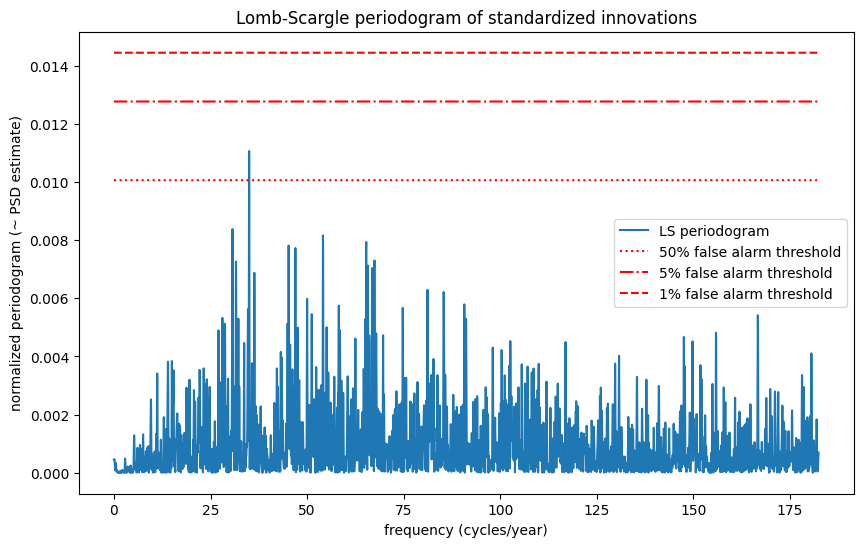

In [33]:
residuals = ssm_res.standardized_forecasts_error[0]
LS = LombScargle(data['Year'], residuals)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
plt.title('Lomb-Scargle periodogram of standardized innovations')
plt.ylabel('normalized periodogram (~ PSD estimate)')

## Static trend + stocastic annual cycle + white noise

In [34]:


#frequency of the annual cycle
frequencies = [{'period': 365, 'harmonics': 1}]

# model settings
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': False,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)
ssm_res.summary()

['sigma2.irregular', 'sigma2.freq_seasonal_365(1)']
['level', 'trend', 'freq_seasonal.0', 'freq_seasonal.1']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4

Optimization terminated successfully.
         Current function value: 0.326790
         Iterations: 2
         Function evaluations: 53


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                        Deformations Up   No. Observations:                 1992
Model:                            deterministic trend   Log Likelihood                -650.966
                   + stochastic freq_seasonal(365(1))   AIC                           1305.931
Date:                                Fri, 14 Jun 2024   BIC                           1317.121
Time:                                        07:26:44   HQIC                          1310.041
Sample:                                             0                                         
                                               - 1992                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular             4.531e-13      0.002   2.27e-10      1.000      -0.004       0.004
sigma2.freq_seasonal_365(1)     0.1089      0.005     23.058      0.000       0.100       0.118
===================================================================================
Ljung-Box (L1) (Q):                  24.08   Jarque-Bera (JB):                65.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.17
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Integrated +  stocastic annual cycle+ AR

In [35]:
frequencies = [{'period': 365, 'harmonics': 1}]

model_settings = {
     'irregular': True, 
     'autoregressive': 2,
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}

# State space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# Fit the state space model parameters and states
# First, fit without constraints to get initial parameter estimates
ssm_res = ssm.fit(method='powell', disp=True)

# Extract the fitted values
fitted_values = ssm_res.fittedvalues

ssm_res.summary()


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.285505
         Iterations: 5
         Function evaluations: 418


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                        Deformations Up   No. Observations:                 1992
Model:                                   smooth trend   Log Likelihood                -568.725
                   + stochastic freq_seasonal(365(1))   AIC                           1149.450
                                              + AR(2)   BIC                           1183.019
Date:                                Fri, 14 Jun 2024   HQIC                          1161.780
Time:                                        07:26:48                                         
Sample:                                             0                                         
                                               - 1992                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular             6.712e-08      0.005   1.26e-05      1.000      -0.010       0.010
sigma2.trend                 3.366e-08   2.82e-08      1.193      0.233   -2.16e-08     8.9e-08
sigma2.freq_seasonal_365(1)     0.0036      0.001      2.769      0.006       0.001       0.006
sigma2.ar                       0.0940      0.012      8.119      0.000       0.071       0.117
ar.L1                           1.0289      0.066     15.651      0.000       0.900       1.158
ar.L2                          -0.2012      0.063     -3.171      0.002      -0.326      -0.077
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                87.03
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.26
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0.92, 'Model Components static trend + stocastic Seasonal + AR(2) ')

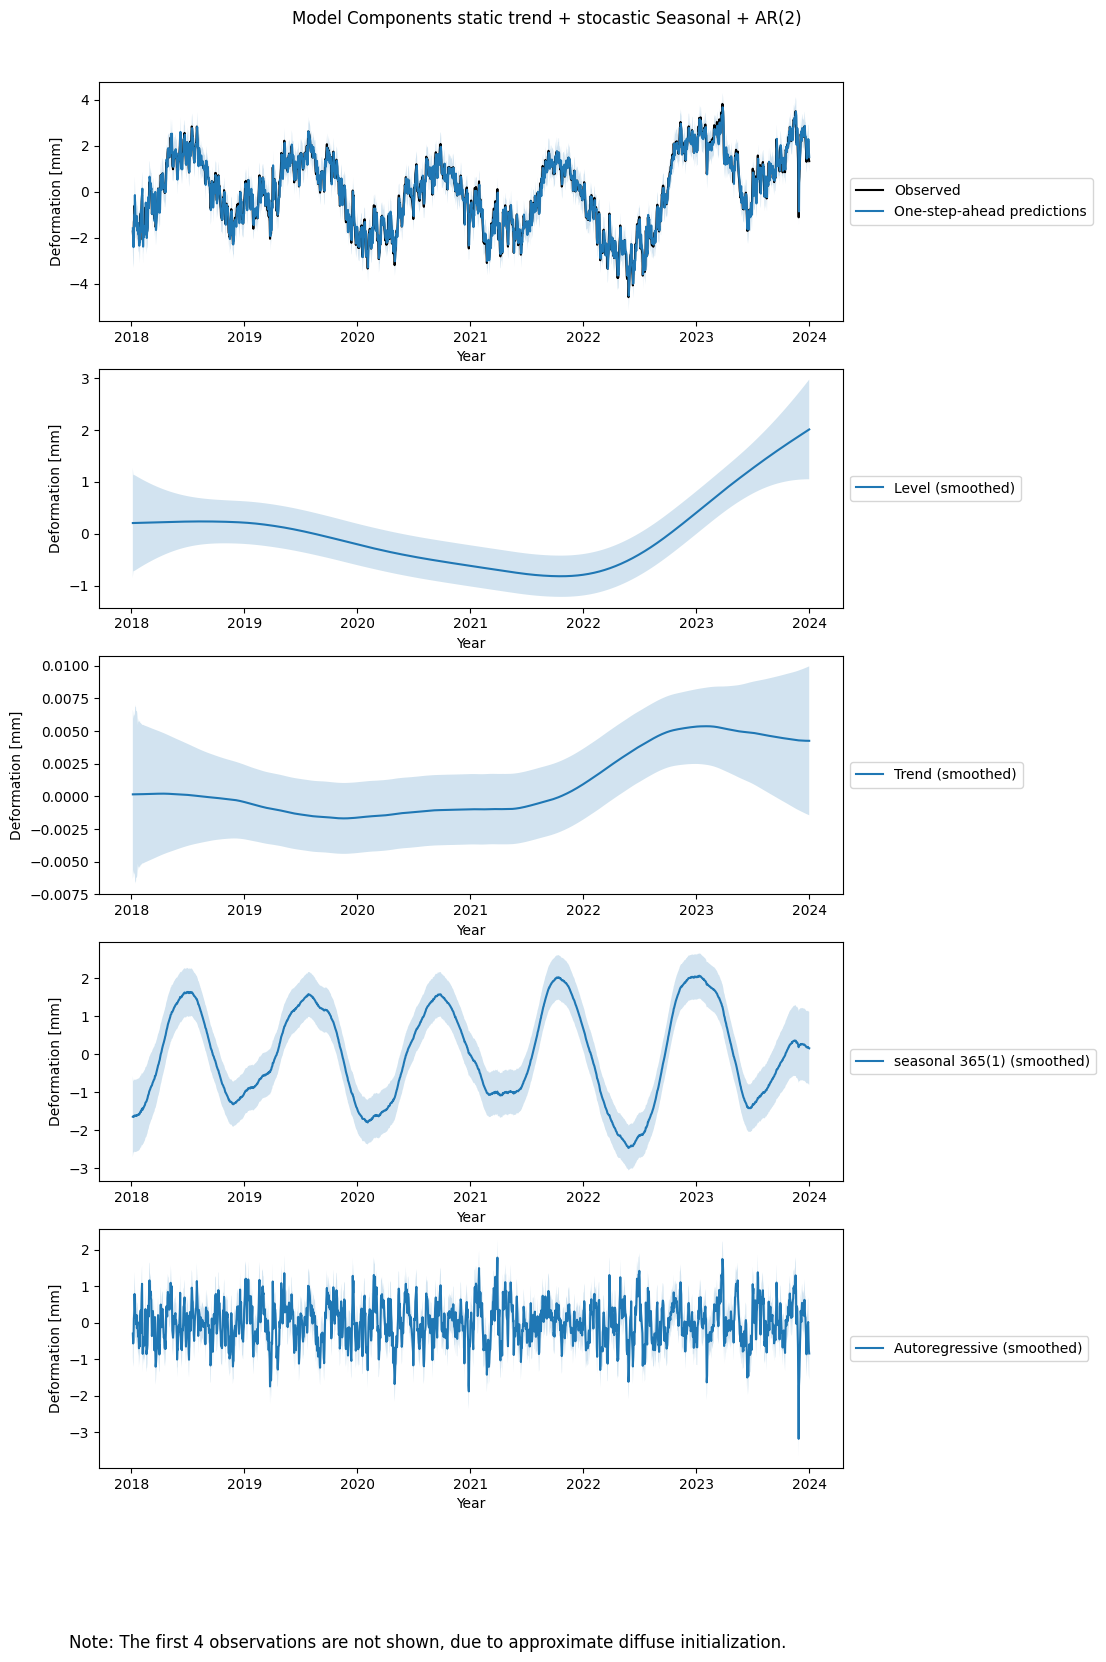

In [36]:

# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components static trend + stocastic Seasonal + AR(2) ", y=0.92)


** check residuals and see if there is still a lot of power at a specific frequenccy or if its evenly spread **

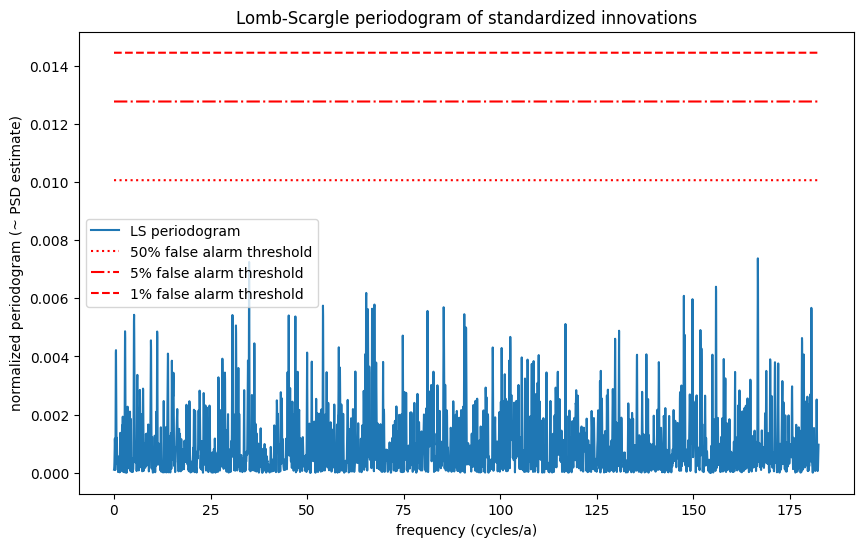

In [37]:
residuals = ssm_res.standardized_forecasts_error[0]
LS = LombScargle(data['Year'], residuals)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/a)')
plt.title('Lomb-Scargle periodogram of standardized innovations')
plt.ylabel('normalized periodogram (~ PSD estimate)')

folder = '/Users/isabelslingerland/master AES/year 1/Q4/Lab/figures'
filename = 'periodogram_aftercheck_norg_up.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)

** check stationarity using adfuller **

In [38]:
adf_test(fitted_values)


Results of Dickey-Fuller Test:
Test Statistic                   -2.827979
p-value                           0.054387
#Lags Used                        9.000000
Number of Observations Used    1982.000000
Critical Value (1%)              -3.433654
Critical Value (5%)              -2.862999
Critical Value (10%)             -2.567547
dtype: float64


Text(0, 0.5, 'Deformations Up [mm]')

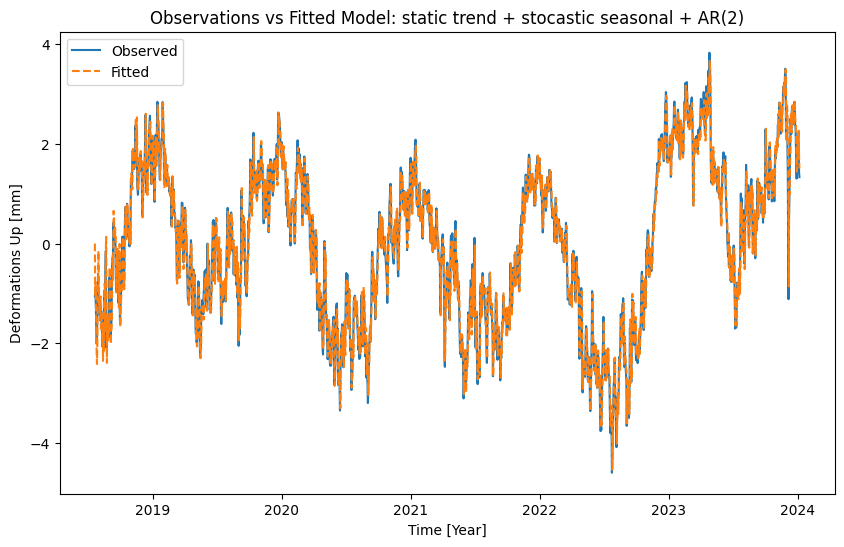

In [39]:
#plot best fit model and observations
plt.figure(figsize=(10, 6))
plt.plot(data['Year'],data['Deformations Up'], label='Observed')
plt.plot(data['Year'],fitted_values, label='Fitted', linestyle='--')
plt.legend()
plt.title('Observations vs Fitted Model: static trend + stocastic seasonal + AR(2)')
plt.xlabel('Time [Year]')
plt.ylabel('Deformations Up [mm]')



Standard deviation (sigma) of the residuals: 0.32386375808306544


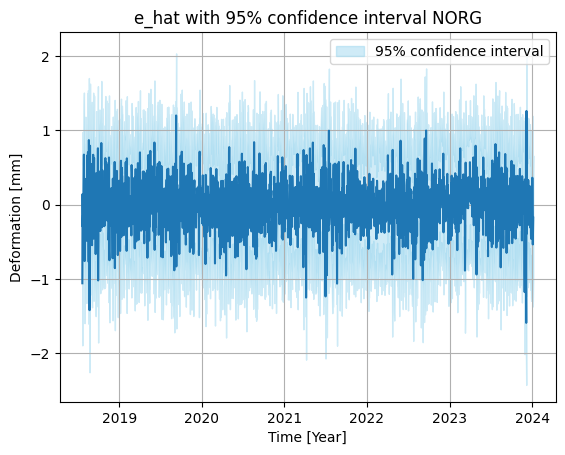

In [40]:
#plot observations and get statistics about residuals
obs_cov_matrix = ssm_res.filter_results.obs_cov

state_cov_matrix = ssm_res.filter_results.state_cov

residuals = ssm_res.resid
sigma = np.std(residuals)
print("Standard deviation (sigma) of the residuals:", sigma)

plt.plot(data['Year'], residuals)
ehat_int = norm.ppf(.995, scale = sigma )
ehatplus = residuals + ehat_int
ehatmin = residuals - ehat_int

plt.fill_between(data['Year'], ehatplus, ehatmin, color='skyblue', alpha=0.4, label='95% confidence interval')
plt.legend()
plt.title(f'e_hat with 95% confidence interval NORG')
plt.xlabel('Time [Year]')
plt.ylabel('Deformation [mm]')
plt.grid()



## Looking into the noise | GNSS station
Power-law noise (linked to PSD) which is a long memory noise process
using LS-VCE and Maximum likelihood



In [45]:
# The description is given above
time = data['Year'].values
# time series observations
y = data['Deformations Up'].values # N or E
m = len(y)
print(f' m{y.size}')
# sampling interval
dt = 1/365.25
# design matrix based on y(t) = y0 + rt + e(t) 
A = np.ones((m,4))
A[:,1] = time
A[:,2] = np.cos(2*np.pi*time)
A[:,3] = np.sin(2*np.pi*time)
m, n = A.shape

# making cofactor matrix assuming only white noise: Qyy=sigma_w^2*I (only one variance component)
Qcf = np.zeros((m, m, 1))
Qcf[:,:,0] = np.eye(m,m) 
# or alternatively you can use pl_cofactor with kappa=0
# Qcf[:,:,0] = pl_cofactor(0, time, dt)
# initilize the variance component (only one)
sig0 = np.array([1])
# apply LS-VCE to estimate the only variance and Qyy
Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
Qyyi = linalg.inv(Qyy)
# BLUE estimate of x
xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
# BLUE estimate of y
yhat = A @ xhat;                         
# BLUE estimate of e (residuals)
ehat = y - yhat;
# compute Log-Likelihood for white-noise model
log_like = log_likelihood(Qyy, ehat)
print('Log-Likelihood of white noise = ',log_like)

# making cofactor matrices assuming white noise + power-law noise: Qyy=sigma_w^2*I+sigma_pl^2*Qpl
Qcf = np.zeros((m, m, 2))
print(f'Qcf{Qcf.shape}')
print(f'time{time.size}')
# white noise part (Q1)
Qcf[:,:,0] = pl_cofactor(0, time, dt)
#set values for kappa
kappa = np.arange(0.4, 2.0, 0.4)
# initialize log-likelihoods
log_like = np.zeros((len(kappa),1))
for i in range(len(kappa)):
    print('\nKappa = ',kappa[i])
    # make power-law cofactor matrix (Q2)
    Qcf[:,:,1] = pl_cofactor(kappa[i], time, dt)    
    # initilize variance components
    sig0 = np.array([1,0])
    # apply LS-VCE to estimate the two variances
    Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
    Qyyi = linalg.inv(Qyy)
    # BLUE estimate of x
    xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
    # BLUE estimate of y
    yhat = A @ xhat;                         
    # BLUE estimate of e (residuals)
    ehat = y - yhat;
    # compute Log-Likelihood for white-noise + power-law noise model
    log_like[i] = log_likelihood(Qyy, ehat)
    print('Log-Likelihood = ', log_like[i])

 m1992
Iteration 1, Estimated variances: [1.19692349]
Iteration 2, Estimated variances: [1.19692349]
Log-Likelihood of white noise =  (-3003.5610500630373+0j)
Qcf(1992, 1992, 2)
time1992
H (1996, 1)

Kappa =  0.4
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         14.84467936]
Iteration 2, Estimated variances: [0.         1.08936242]
Iteration 3, Estimated variances: [0.         1.08936242]


/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_60378/4291953425.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  log_like[i] = log_likelihood(Qyy, ehat)


Log-Likelihood =  [-1734.42958638]

Kappa =  0.8
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         33.41407393]
Iteration 2, Estimated variances: [0.         1.80372982]
Iteration 3, Estimated variances: [0.         1.80372982]
Log-Likelihood =  [-1061.40429482]

Kappa =  1.2000000000000002
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         18.36303004]
Iteration 2, Estimated variances: [0.         4.33604447]
Iteration 3, Estimated variances: [0.         4.33604447]
Log-Likelihood =  [-759.78052243]

Kappa =  1.6
H (1996, 1)
Iteration 1, Estimated variances: [0.05921363 6.95642355]
Iteration 2, Estimated variances: [ 0.         15.56754264]
Iteration 3, Estimated variances: [ 0.         12.48874316]
Iteration 4, Estimated variances: [ 0.         12.48874317]
Iteration 5, Estimated variances: [ 0.         12.48874317]
Iteration 6, Estimated variances: [ 0.         12.48874317]
Log-Likelihood =  [-638.23140334]


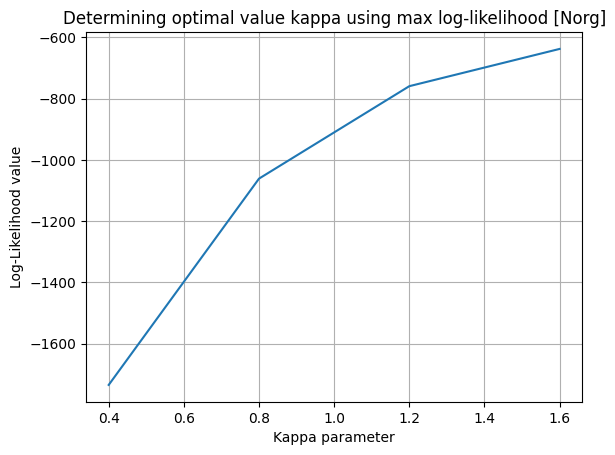

In [46]:
# plot Log-Likelihoods vs. kappa. determine optimal value for kappa, providing the max log-likelihood
plt.plot(kappa, log_like)
plt.xlabel('Kappa parameter')
plt.ylabel('Log-Likelihood value')
plt.title('Determining optimal value kappa using max log-likelihood [Norg]')
plt.grid()

folder = '/Users/isabelslingerland/master AES/year 1/Q4/Lab/figures'
filename = 'optimalkappa_norg_up.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)


## solving the static model + Power law noise

In [47]:
# making cofactor matrices assuming white noise + power-law noise: Qyy=sigma_w^2*I+sigma_pl^2*Qpl
Qcf = np.zeros((m, m, 2))
# white noise part (Q1)
Qcf[:,:,0] = pl_cofactor(0, time, dt)
# the value that gives the maximum value for log_like
kappa_optimal = 2
# power-law cofactor matrix (Q2)
Qcf[:,:,1] = pl_cofactor(kappa_optimal, time, dt)    
# initilize variance components
sig0 = np.array([1,0])
# apply LS-VCE to estimate the two variances and therefore the final Qyy
Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
Qyyi = linalg.inv(Qyy)
    # BLUE estimate of x
xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y
    # BLUE estimate of y
yhat = A @ xhat;                         
    # BLUE estimate of e (residuals)
ehat = y - yhat;

H (1996, 1)
H (1996, 1)
Iteration 1, Estimated variances: [0.38043645 2.3162495 ]
Iteration 2, Estimated variances: [ 0.14576161 10.31622071]
Iteration 3, Estimated variances: [ 0.04121847 26.67057123]
Iteration 4, Estimated variances: [ 0.         41.64601001]
Iteration 5, Estimated variances: [ 0.         39.77690895]
Iteration 6, Estimated variances: [ 0.         39.77690895]
Iteration 7, Estimated variances: [ 0.         39.77690893]
Iteration 8, Estimated variances: [ 0.         39.77690896]
Iteration 9, Estimated variances: [ 0.         39.77690904]
Iteration 10, Estimated variances: [ 0.        39.7769089]


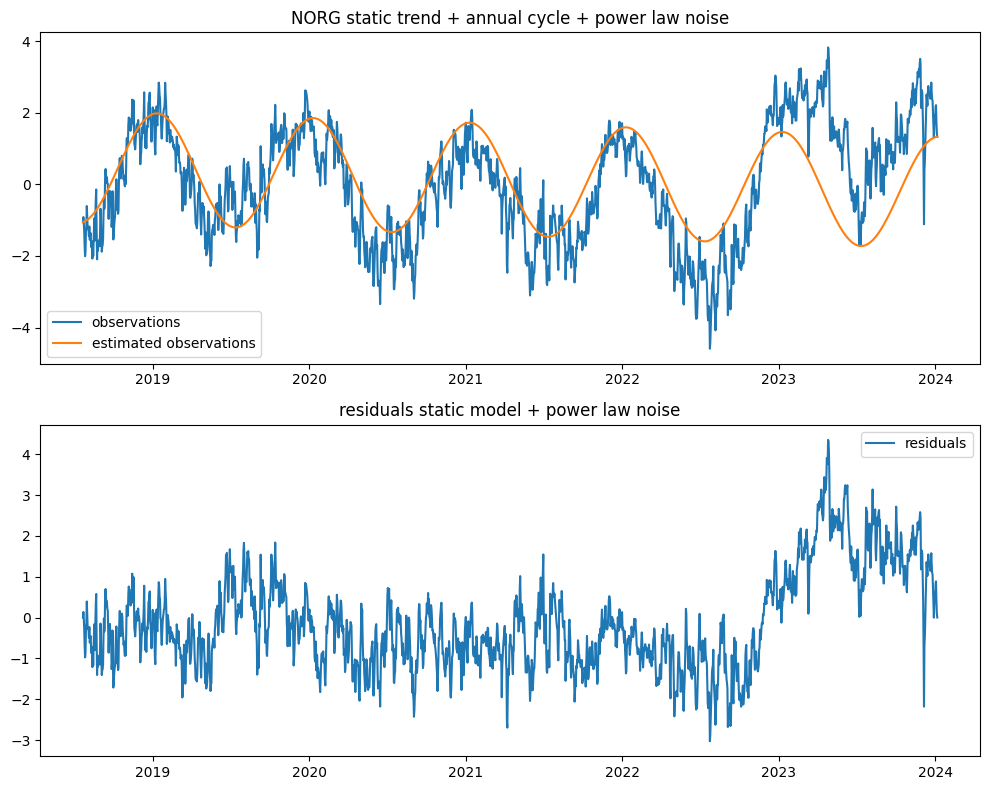

In [48]:
# Fit the static model to the observations and the residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# First subplot
ax[0].plot(data['Year'], data['Deformations Up'], label='observations')
ax[0].plot(data['Year'], yhat, label='estimated observations')
ax[0].set_title('NORG static trend + annual cycle + power law noise')
ax[0].legend()

# Second subplot
ax[1].plot(data['Year'], ehat, label='residuals')
ax[1].set_title('residuals static model + power law noise')
ax[1].legend()

# Display the plot
plt.tight_layout()
plt.savefig('static model power noise')
plt.show()

# Playing around with Insar time series

In [49]:
#load guis timeseries for lineofsight insar
import pickle

with open('ls_phase_arr_preprocesseds.pkl', 'rb') as f:
    ls_phase= pickle.load(f)



In [50]:
ls_phase = ls_phase[0][0]


In [51]:
# phase to deformation in mm line of sight
arc_deformation = compute_arc_deformation_mm(ls_phase)

In [52]:
# from line of sight to vertical deformation
vertical = get_vertical(arc_deformation, np.radians(43.11))


In [53]:
#time array
t= np.array([2019.24657534, 2019.2630137 , 2019.27945205, 2019.29589041,
       2019.31232877, 2019.32876712, 2019.34520548, 2019.36164384,
       2019.42739726, 2019.44383562, 2019.46027397, 2019.5260274 ,
       2019.60821918, 2019.62465753, 2019.64109589, 2019.77260274,
       2019.7890411 , 2019.80547945, 2019.82191781, 2019.83835616,
       2019.85479452, 2019.87123288, 2019.88767123, 2019.90410959,
       2019.92054795, 2020.00273224, 2020.03551913, 2020.06830601,
       2020.1010929 , 2020.21584699, 2020.23224044, 2020.24863388,
       2020.26502732, 2020.28142077, 2020.29781421, 2020.33060109,
       2020.51092896, 2020.5273224 , 2020.54371585, 2020.62568306,
       2020.65846995, 2020.69125683, 2020.70765027, 2020.74043716,
       2020.77322404, 2020.78961749, 2020.82240437, 2020.83879781,
       2020.85519126, 2020.8715847 , 2020.88797814, 2020.92076503,
       2021.08493151, 2021.16712329, 2021.21643836, 2021.24931507,
       2021.26575342, 2021.28219178, 2021.29863014, 2021.31506849,
       2021.34794521, 2021.4630137 , 2021.47945205, 2021.51232877,
       2021.52876712, 2021.56164384, 2021.57808219, 2021.59452055,
       2021.6109589 , 2021.62739726, 2021.64383562, 2021.66027397,
       2021.70958904, 2021.7260274 , 2021.74246575, 2021.75890411,2021.77534247, 2021.79178082, 2021.80821918, 2021.82465753,
       2021.84109589, 2021.85753425, 2021.8739726 , 2021.89041096,
       2021.93972603, 2021.95616438, 2021.97260274, 2022.07123288,
       2022.20273973, 2022.23561644, 2022.30136986, 2022.33424658,
       2022.46575342, 2022.49863014, 2022.53150685, 2022.56438356,
       2022.59726027, 2022.63013699, 2022.6630137 , 2022.69589041,
       2022.76164384, 2022.79452055, 2022.82739726, 2022.86027397,
       2022.89315068, 2022.9260274 , 2022.95890411, 2023.05753425,
       2023.12328767, 2023.15616438, 2023.25479452, 2023.28767123,
       2023.32054795, 2023.38630137, 2023.41917808, 2023.48493151,
       2023.68219178, 2023.71506849
])


### testing dynamic time series

we choose the best model stocastic trend + stocastic annual cycle + AR(1)

In [54]:

frequencies = [{'period': 365, 'harmonics': 1}]

model_settings = {
     'irregular': False, 
     'autoregressive': 1,
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': False,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}
# ssm = state space model
ssm = sm.tsa.UnobservedComponents(vertical[766,:], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)
ssm_res.summary()

['sigma2.freq_seasonal_365(1)', 'sigma2.ar', 'ar.L1']
['level', 'trend', 'freq_seasonal.0', 'freq_seasonal.1', 'ar.L1']


4

Optimization terminated successfully.
         Current function value: 2.605152
         Iterations: 2
         Function evaluations: 67


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  118
Model:                                           None   Log Likelihood                -307.408
                   + stochastic freq_seasonal(365(1))   AIC                            620.816
                                              + AR(1)   BIC                            629.025
Date:                                Fri, 14 Jun 2024   HQIC                           624.147
Time:                                        07:53:27                                         
Sample:                                             0                                         
                                                - 118                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.freq_seasonal_365(1)  3.684e-10      0.096   3.82e-09      1.000      -0.189       0.189
sigma2.ar                       9.5214      1.457      6.534      0.000       6.665      12.377
ar.L1                          -0.4528      0.097     -4.659      0.000      -0.643      -0.262
===================================================================================
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):                 2.45
Prob(Q):                              0.15   Prob(JB):                         0.29
Heteroskedasticity (H):               0.68   Skew:                            -0.27
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Extract the fitted values
residuals = ssm_res.resid
fitted_values = ssm_res.fittedvalues
standardized_residuals = ssm_res.filter_results.standardized_forecasts_error[0]
exog = np.column_stack([np.ones(len(fitted_values)), np.arange(len(fitted_values))])
bp_test = het_breuschpagan(residuals, exog)
print('Breusch-Pagan test statistic:', bp_test[0])
print('p-value:', bp_test[1])
print('f-value:', bp_test[2])
print('f p-value:', bp_test[3])

adf_test(fitted_values)

NameError: name 'het_breuschpagan' is not defined

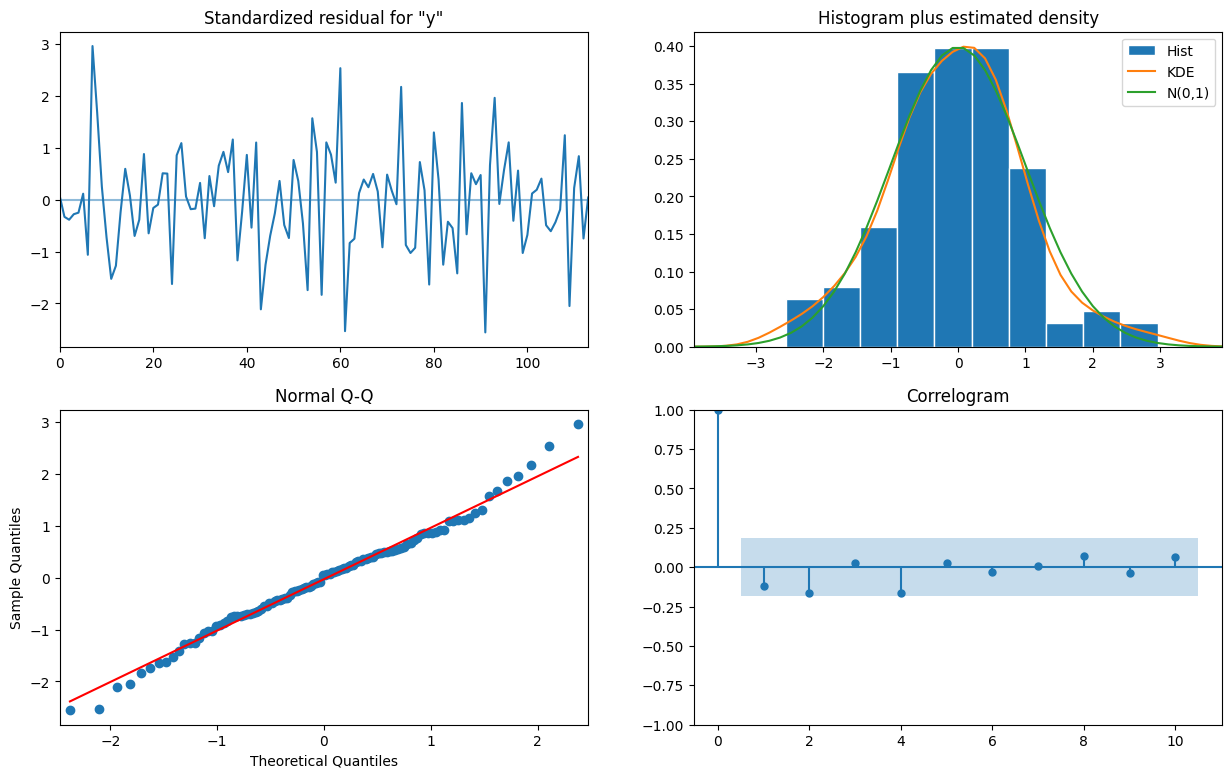

In [ ]:
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))


Text(0, 0.5, 'Deformations Up [mm]')

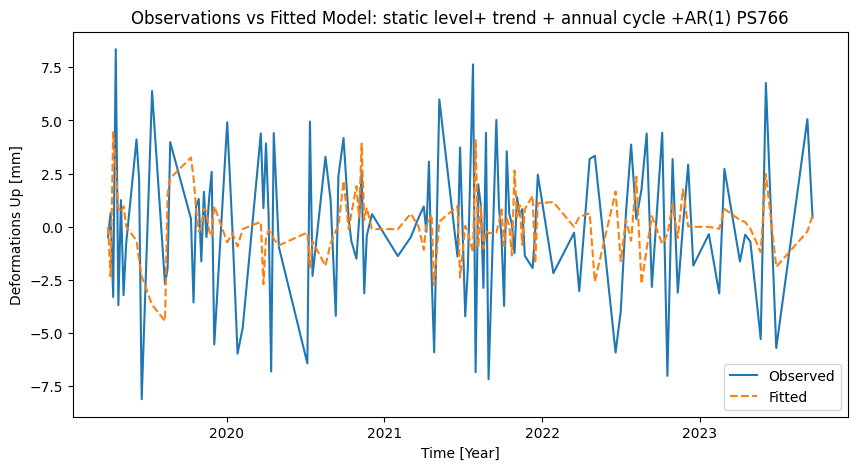

In [ ]:

#plot obs and best model
plt.figure(figsize=(10, 5))
plt.plot(t,vertical[766], label='Observed')
plt.plot(t,fitted_values, label='Fitted', linestyle='--')
plt.legend()
plt.title('Observations vs Fitted Model: static level+ trend + annual cycle +AR(1) PS766')
plt.xlabel('Time [Year]')
plt.ylabel('Deformations Up [mm]')


** check periodogram of residuals **

Text(0, 0.5, 'normalized periodogram (~ PSD estimate)')

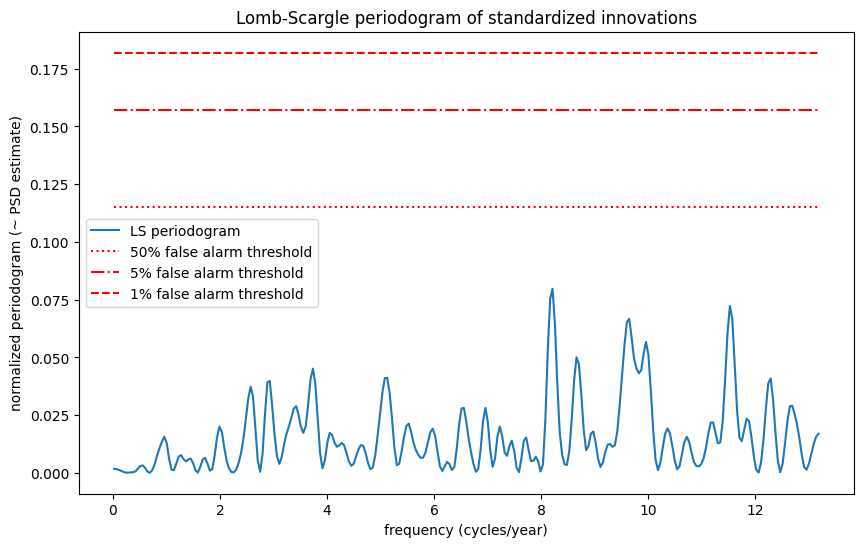

In [56]:
residuals = ssm_res.standardized_forecasts_error[0]
LS = LombScargle(t, residuals)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
plt.title('Lomb-Scargle periodogram of standardized innovations')
plt.ylabel('normalized periodogram (~ PSD estimate)')

# fitting a static model using Least Square and assuming white noise

In [58]:
def fit_static_model(deformations, time):
    # time series observations
    #time= np.array(time)
    y = deformations # N or E
    m = len(y)
    # sampling interval
    #dt = diff[1] time series observations

   
    # design matrix based on y(t) = y0 + rt + e(t) 
    A = np.ones((m,4))
    A[:,1] = time
    A[:,2] = np.cos((2*np.pi)*time)
    A[:,3] = np.sin((2*np.pi)*time)
    m, n = A.shape

    # making cofactor matrices of white noise and flicker noise
    Qcf = np.zeros((m, m, 1))
    Qcf[:,:,0] = np.eye(m,m) 
    #Qcf[:,:,1] = pl_cofactor(2, time, dt)
    # initilize variance components
    sig0 = np.array([1])
    # apply LS-VCE to estimate two variance components and Qyy
    Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
    Qyyi = linalg.inv(Qyy)
    # BLUE estimate of x
    xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y
    # BLUE estimate of y
    yhat = A @ xhat;                         
    # BLUE estimate of e (residuals)
    ehat = y - yhat;
    return xhat ,yhat,ehat, Qyy

In [59]:
store_xhat = np.zeros((784,4))
store_yhat = np.zeros((784,118))
store_ehat = np.zeros((784,118))
store_Qyy = np.zeros((784,118,118))
for i in range(784):
    store_xhat[i,:],store_yhat[i,:], store_ehat[i,:], store_Qyy[i,:,:]  = fit_static_model(vertical[i], t)
      

Iteration 1, Estimated variances: [11.94646201]
Iteration 2, Estimated variances: [11.94646201]
Iteration 1, Estimated variances: [12.0544637]
Iteration 2, Estimated variances: [12.0544637]
Iteration 1, Estimated variances: [11.47691861]
Iteration 2, Estimated variances: [11.47691861]
Iteration 1, Estimated variances: [13.35333905]
Iteration 2, Estimated variances: [13.35333905]
Iteration 1, Estimated variances: [16.13288274]
Iteration 2, Estimated variances: [16.13288274]
Iteration 1, Estimated variances: [12.40815564]
Iteration 2, Estimated variances: [12.40815564]
Iteration 1, Estimated variances: [2.91275853]
Iteration 2, Estimated variances: [2.91275853]
Iteration 1, Estimated variances: [0.76609264]
Iteration 2, Estimated variances: [0.76609264]
Iteration 1, Estimated variances: [0.8430576]
Iteration 2, Estimated variances: [0.8430576]
Iteration 1, Estimated variances: [2.21042665]
Iteration 2, Estimated variances: [2.21042665]
Iteration 1, Estimated variances: [0.23255442]
Itera

In [ ]:
# The description is given above
time = t
print(f'time {time.shape}')
# time series observations
y = vertical[40,:] # N or E

m = len(y)
print(f' m {y.size}')
# sampling interval
dt = 1/365.2425
# design matrix based on y(t) = y0 + rt + e(t) 
A = np.ones((m,4))
A[:,1] = time
A[:,2] = np.cos(2*np.pi*time)
A[:,3] = np.sin(2*np.pi*time)
m, n = A.shape

# making cofactor matrix assuming only white noise: Qyy=sigma_w^2*I (only one variance component)
Qcf = np.zeros((m, m, 1))
Qcf[:,:,0] = np.eye(m,m) 
# or alternatively you can use pl_cofactor with kappa=0
# Qcf[:,:,0] = pl_cofactor(0, time, dt)
# initilize the variance component (only one)
sig0 = np.array([1])
# apply LS-VCE to estimate the only variance and Qyy
Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
Qyyi = linalg.inv(Qyy)
# BLUE estimate of x
xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
# BLUE estimate of y
yhat = A @ xhat;                         
# BLUE estimate of e (residuals)
ehat = y - yhat;
# compute Log-Likelihood for white-noise model
log_like = log_likelihood(Qyy, ehat)
print('Log-Likelihood of white noise = ',log_like)

# making cofactor matrices assuming white noise + power-law noise: Qyy=sigma_w^2*I+sigma_pl^2*Qpl
Qcf = np.zeros((m, m, 2))
print(f'Qcf{Qcf.shape}')
# white noise part (Q1)
Qcf[:,:,0] = pl_cofactor(0, time, dt)
# set values for kappa
kappa = np.arange(0.5, 2.5, 0.5)
# initialize log-likelihoods
log_like = np.zeros((len(kappa),1))
for i in range(len(kappa)):
    print('\nKappa = ',kappa[i])
    # make power-law cofactor matrix (Q2)
    Qcf[:,:,1] = pl_cofactor(kappa[i], time, dt)    
    # initilize variance components
    sig0 = np.array([1,0])
    # apply LS-VCE to estimate the two variances
    Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
    Qyyi = linalg.inv(Qyy)
    # BLUE estimate of x
    xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
    # BLUE estimate of y
    yhat = A @ xhat;                         
    # BLUE estimate of e (residuals)
    ehat = y - yhat;
    # compute Log-Likelihood for white-noise + power-law noise model
    log_like[i] = log_likelihood(Qyy, ehat)
    print('Log-Likelihood = ', log_like[i])

time (118,)
 m 118
Iteration 1, Estimated variances: [17.02906081]
Iteration 2, Estimated variances: [17.02906081]
Log-Likelihood of white noise =  (-332.6951062317104+0j)
Qcf(118, 118, 2)
H (1633, 1)

Kappa =  0.5
H (1633, 1)
Iteration 1, Estimated variances: [17.02906081  0.        ]
Iteration 2, Estimated variances: [17.02906081  0.        ]
Log-Likelihood =  [-332.69510623]

Kappa =  1.0
H (1633, 1)


/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_37696/2833813928.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  log_like[i] = log_likelihood(Qyy, ehat)


Iteration 1, Estimated variances: [17.02906081  0.        ]
Iteration 2, Estimated variances: [17.02906081  0.        ]
Log-Likelihood =  [-332.69510623]

Kappa =  1.5
H (1633, 1)
Iteration 1, Estimated variances: [17.02906081  0.        ]
Iteration 2, Estimated variances: [17.02906081  0.        ]
Log-Likelihood =  [-332.69510623]

Kappa =  2.0
H (1633, 1)
Iteration 1, Estimated variances: [17.02906081  0.        ]
Iteration 2, Estimated variances: [17.02906081  0.        ]
Log-Likelihood =  [-332.69510623]


In [ ]:
store_T_q = np.zeros(738)
for i in range(738):
    store_T_q[i] = overall_model_test(store_ehat[i,:], store_Qyy[i,:,:])


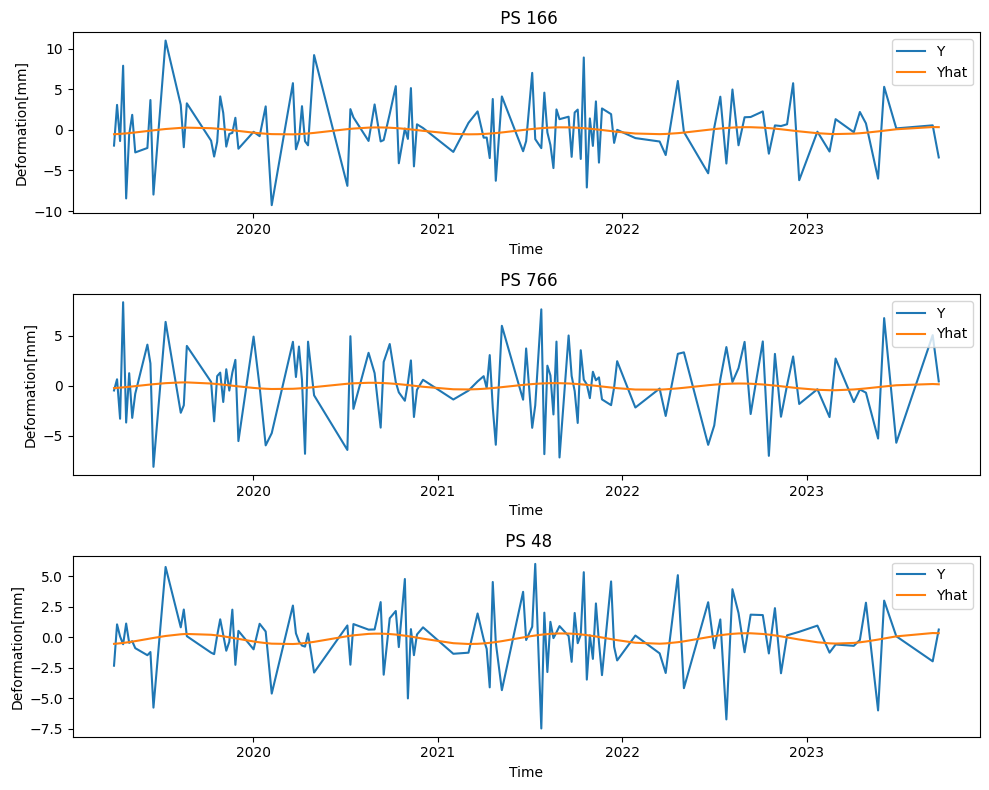

In [ ]:

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# First subplot
axes[0].plot(t, vertical[166], label='Y')
axes[0].plot(t, store_yhat[48,:], label='Yhat')
axes[0].legend()
axes[0].set_title(' PS 166')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Deformation[mm]')

# Second subplot
axes[1].plot(t, vertical[766], label='Y')
axes[1].plot(t, store_yhat[766,:], label='Yhat')
axes[1].legend()
axes[1].set_title(' PS 766')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Deformation[mm]')

# Third subplot
axes[2].plot(t, vertical[48], label='Y')
axes[2].plot(t, store_yhat[48,:], label='Yhat')
axes[2].legend()
axes[2].set_title(' PS 48')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Deformation[mm]')

# Adjust layout
plt.tight_layout()

# Show the plot

plt.savefig('insar_fitted_plot.png')